# Assignment 2 : Netflix Stocks

## Plotting closing prices

In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 1, 30)
nflx = web.DataReader('NFLX', 'yahoo', start, end)
nflx.head(10) 

High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2014-01-02  52.511429  51.542858  52.401428  51.831429  12325600.0  51.831429
2014-01-03  52.495716  51.842857  52.000000  51.871429  10817100.0  51.871429
2014-01-06  52.044285  50.475716  51.889999  51.367142  15501500.0  51.367142
2014-01-07  49.698570  48.152859  49.684284  48.500000  36167600.0  48.500000
2014-01-08  49.425713  48.074287  48.104286  48.712856  20001100.0  48.712856
2014-01-09  49.139999  47.857143  48.824287  48.150002  17007200.0  48.150002
2014-01-10  48.377144  47.218571  48.295715  47.448570  16237900.0  47.448570
2014-01-13  49.810001  47.304287  47.304287  48.115715  27237000.0  48.115715
2014-01-14  48.799999  47.509998  48.777142  48.279999  19740000.0  48.279999
2014-01-15  48.367142  45.581429  47.857143  47.197144  40432000.0  47.197144

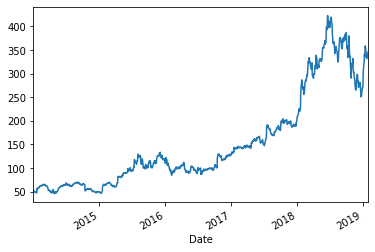

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
high = nflx['High']
high.plot()

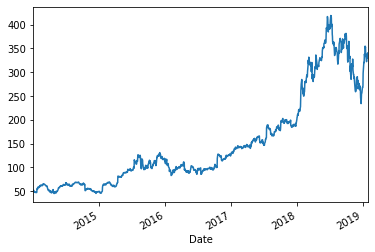

In [3]:
close = nflx['Close']
close.plot()

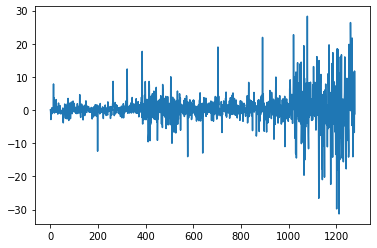

In [4]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)

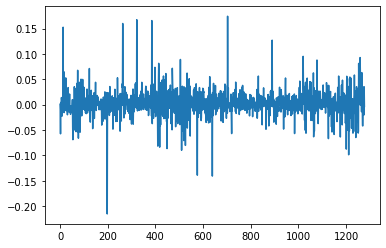

In [5]:
import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

In [7]:
high.corr(close)
# a value of 0.3 essentially means little correlation..

0.9995904149031909

# 1. Exploratory Data Analysis(EDA)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

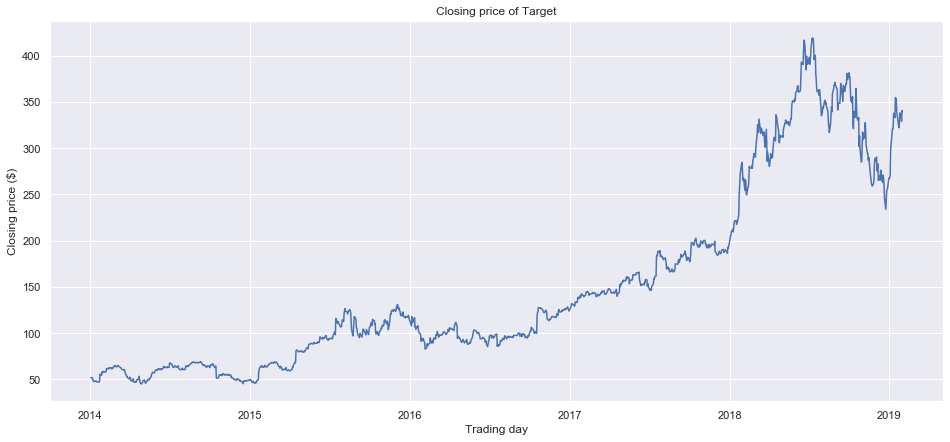

In [9]:
# Plot closing price
plt.figure(figsize=(16, 7))
plt.plot(nflx.Close)
plt.title('Closing price of Target')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(True)
plt.show()

# 2. Moving Average

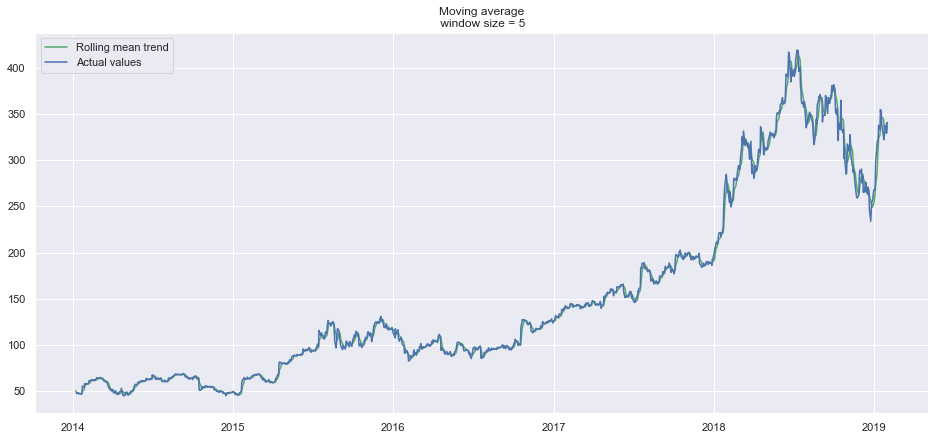

In [10]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(16,7))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(nflx.Close, 5)

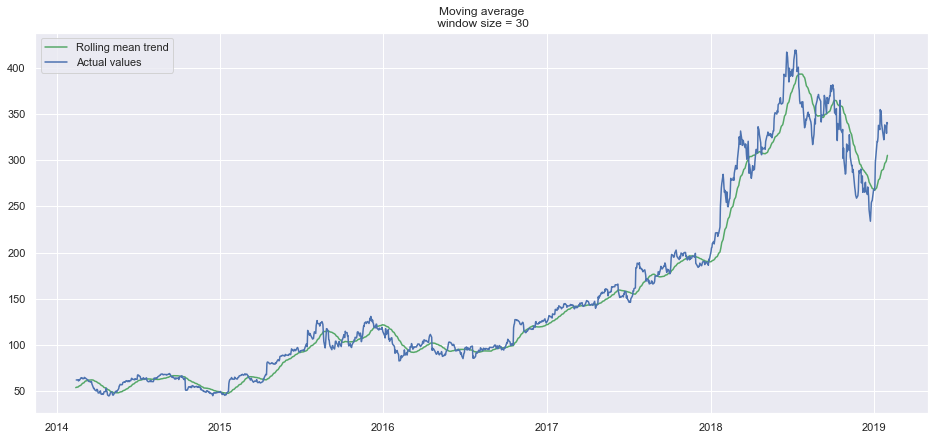

In [11]:
#Smooth by the previous month
plot_moving_average(nflx.Close, 30)

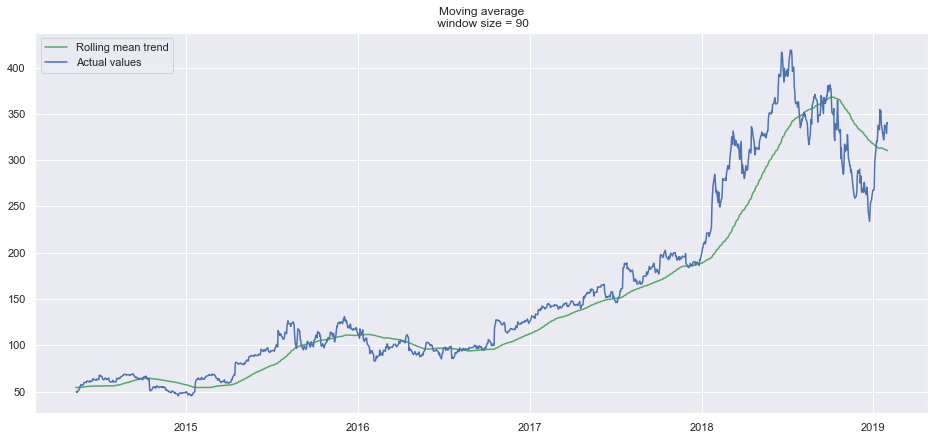

In [12]:
#Smooth by the previous quarter
plot_moving_average(nflx.Close, 90)

# 3. Exponential Smoothing

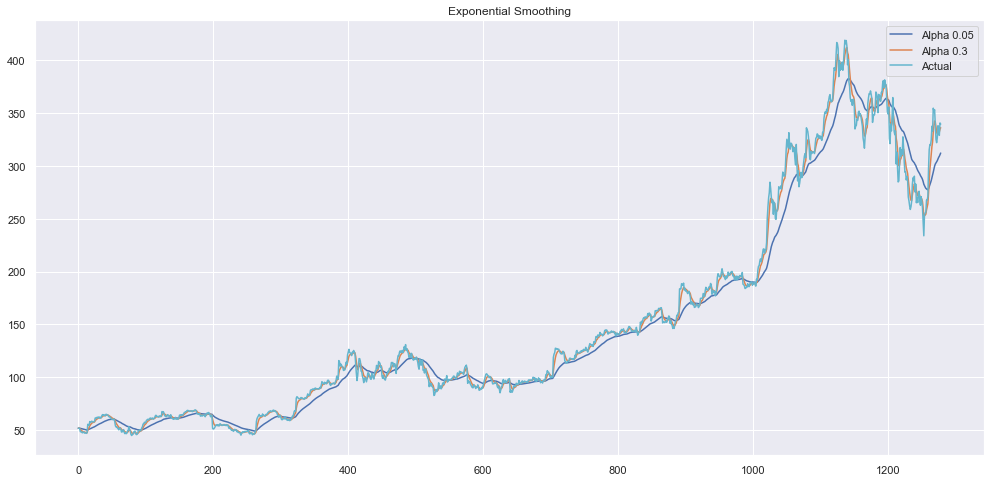

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(nflx.Close, [0.05, 0.3])

# 4. Double Exponential Smoothing

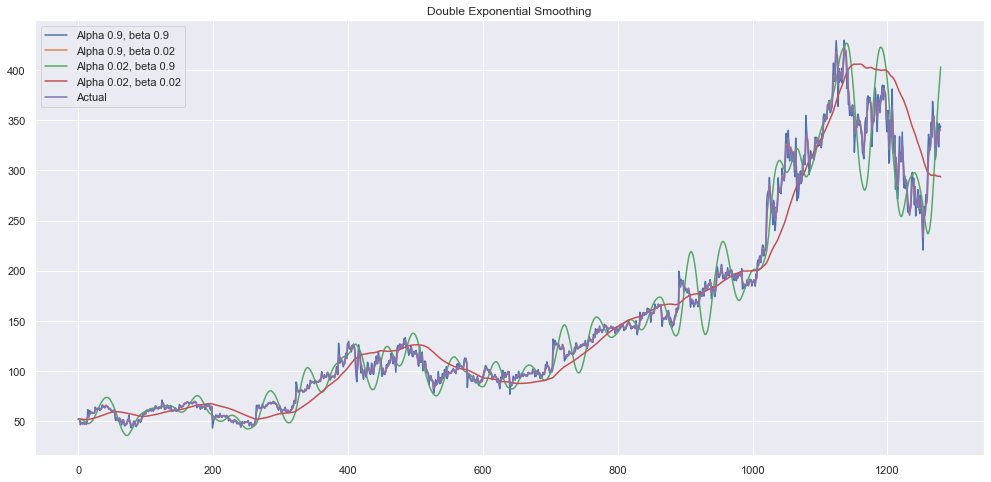

In [14]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(nflx.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# 5. Modeling

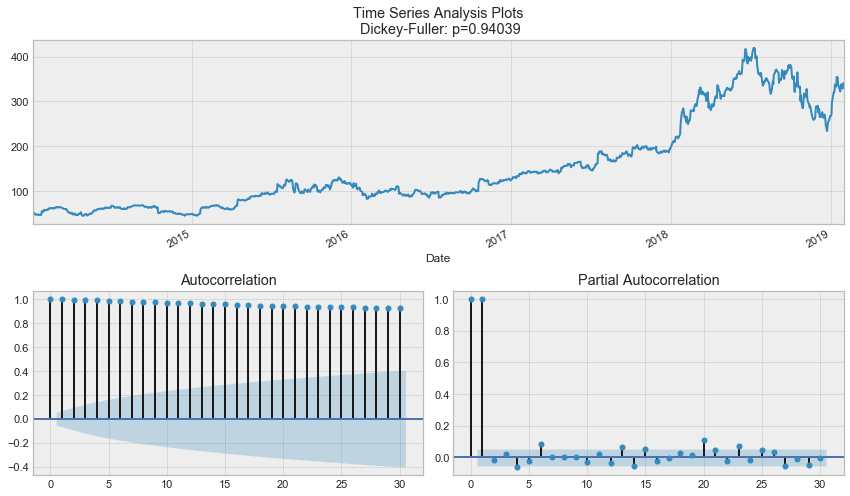

In [15]:
import statsmodels.api as sm
import statsmodels as smt
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(nflx.Close, lags=30)

# 6. Prediction of Stock using Random Forest

In [16]:
nflx.head()

High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2014-01-02  52.511429  51.542858  52.401428  51.831429  12325600.0  51.831429
2014-01-03  52.495716  51.842857  52.000000  51.871429  10817100.0  51.871429
2014-01-06  52.044285  50.475716  51.889999  51.367142  15501500.0  51.367142
2014-01-07  49.698570  48.152859  49.684284  48.500000  36167600.0  48.500000
2014-01-08  49.425713  48.074287  48.104286  48.712856  20001100.0  48.712856

In [17]:
dfreg = nflx.loc[:,['Adj Close', 'Volume']]
dfreg['HighLow_PCT'] = (nflx['High'] - nflx['Low']) / nflx['Close'] * 100.0
dfreg['PCT_change'] = (nflx['Close'] - nflx['Open']) / nflx['Open'] * 100.0
dfreg

Adj Close      Volume  HighLow_PCT  PCT_change
Date                                                       
2014-01-02   51.831429  12325600.0     1.868694   -1.087756
2014-01-03   51.871429  10817100.0     1.258609   -0.247251
2014-01-06   51.367142  15501500.0     3.053643   -1.007627
2014-01-07   48.500000  36167600.0     3.187034   -2.383619
2014-01-08   48.712856  20001100.0     2.774268    1.265106
...                ...         ...          ...         ...
2019-01-25  338.049988  11152900.0     3.398903    2.838278
2019-01-28  335.660004   8652100.0     2.210565    0.286821
2019-01-29  328.899994   7655200.0     3.061723   -2.075208
2019-01-30  340.660004   9234500.0     3.223158    2.377161
2019-01-31  339.500000   8535500.0     2.326950   -0.052989

[1279 rows x 4 columns]

In [18]:
dfreg.fillna(value=-99999, inplace=True)

In [19]:
import math
forecast = int(math.ceil(0.594 * len(dfreg)))
forecast

760

In [20]:
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast)
X = np.array(dfreg.drop(['label'], 1))
dfreg

Adj Close      Volume  HighLow_PCT  PCT_change       label
Date                                                                   
2014-01-02   51.831429  12325600.0     1.868694   -1.087756  130.949997
2014-01-03   51.871429  10817100.0     1.258609   -0.247251  129.889999
2014-01-06   51.367142  15501500.0     3.053643   -1.007627  130.500000
2014-01-07   48.500000  36167600.0     3.187034   -2.383619  129.179993
2014-01-08   48.712856  20001100.0     2.774268    1.265106  133.699997
...                ...         ...          ...         ...         ...
2019-01-25  338.049988  11152900.0     3.398903    2.838278         NaN
2019-01-28  335.660004   8652100.0     2.210565    0.286821         NaN
2019-01-29  328.899994   7655200.0     3.061723   -2.075208         NaN
2019-01-30  340.660004   9234500.0     3.223158    2.377161         NaN
2019-01-31  339.500000   8535500.0     2.326950   -0.052989         NaN

[1279 rows x 5 columns]

In [21]:
dfreg.tail(700)

Adj Close      Volume  HighLow_PCT  PCT_change  label
Date                                                              
2016-04-21   94.980003  19919400.0     2.737417   -2.394404    NaN
2016-04-22   95.900002  15806300.0     2.586031    1.107014    NaN
2016-04-25   93.559998  14985400.0     3.153054   -2.236154    NaN
2016-04-26   92.430000  15330900.0     2.488373   -1.144385    NaN
2016-04-27   91.040001  12218900.0     2.515379   -1.236710    NaN
...                ...         ...          ...         ...    ...
2019-01-25  338.049988  11152900.0     3.398903    2.838278    NaN
2019-01-28  335.660004   8652100.0     2.210565    0.286821    NaN
2019-01-29  328.899994   7655200.0     3.061723   -2.075208    NaN
2019-01-30  340.660004   9234500.0     3.223158    2.377161    NaN
2019-01-31  339.500000   8535500.0     2.326950   -0.052989    NaN

[700 rows x 5 columns]

In [22]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [23]:
X_lately = X[-forecast:]
X = X[:-forecast]
X

array([[-0.9973961 , -0.1449508 , -0.66461681, -0.53125032],
       [-0.99698969, -0.29296628, -1.00061664, -0.13494748],
       [-1.00211323,  0.16667158, -0.012014  , -0.49346905],
       ...,
       [-0.48412992,  1.69009771,  1.75542252, -2.61704644],
       [-0.50069061,  1.27743036,  1.46128282, -1.81938191],
       [-0.51694652,  0.63957539,  0.35094155, -0.3302452 ]])

In [24]:
import numpy as np
y = np.array(dfreg['label'])
y
y = y[:-forecast]
y

array([130.94999695, 129.88999939, 130.5       , 129.17999268,
       133.69999695, 132.88999939, 133.25999451, 138.41000366,
       138.6000061 , 137.38999939, 140.11000061, 139.52000427,
       138.96000671, 142.44999695, 141.22000122, 140.71000671,
       140.77999878, 139.19999695, 140.25      , 140.97000122,
       144.        , 144.74000549, 144.13999939, 144.82000732,
       143.19999695, 140.82000732, 142.27000427, 142.00999451,
       142.22000122, 142.6000061 , 143.86000061, 142.77999878,
       143.25      , 143.41000366, 142.13000488, 142.6499939 ,
       139.52999878, 139.13999939, 141.94000244, 141.42999268,
       140.32000732, 140.52999878, 140.88999939, 143.52000427,
       143.19000244, 145.25      , 144.38999939, 145.11000061,
       145.83000183, 142.41999817, 142.6499939 , 141.83999634,
       142.02000427, 144.05999756, 145.16999817, 146.47000122,
       148.05999756, 147.80999756, 146.91999817, 145.5       ,
       143.61999512, 143.74000549, 143.11000061, 143.85

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
rf_model = RandomForestRegressor()

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [28]:
rf_model.score(X_test, y_test)

0.7293775121916883

In [29]:
dfreg.tail(761)

Adj Close      Volume  HighLow_PCT  PCT_change  label
Date                                                              
2016-01-25   99.120003  20321100.0     3.712672   -0.661451  339.5
2016-01-26   97.830002  22083900.0     5.826438   -1.914975    NaN
2016-01-27   91.150002  25556200.0     7.964895   -5.651588    NaN
2016-01-28   94.410004  24562300.0     5.444338    0.607425    NaN
2016-01-29   91.839996  20463900.0     4.094079   -0.173917    NaN
...                ...         ...          ...         ...    ...
2019-01-25  338.049988  11152900.0     3.398903    2.838278    NaN
2019-01-28  335.660004   8652100.0     2.210565    0.286821    NaN
2019-01-29  328.899994   7655200.0     3.061723   -2.075208    NaN
2019-01-30  340.660004   9234500.0     3.223158    2.377161    NaN
2019-01-31  339.500000   8535500.0     2.326950   -0.052989    NaN

[761 rows x 5 columns]

After going 761 days in the past, we can predict the future by maintaining 72% accuracy